In [1]:
import sys
sys.path.append(r'/home1/roeyshafran/BrainCap/Mind-Cap/code/Mind_Vis_utils/')

from fmri_caption import GPTCaptionModel, create_fmri_encoder_from_pretrained,top_k_top_p_filtering, set_parameter_requires_grad
from dataset import BOLD5000_dataset, identity
from dataset import create_BOLD5000_dataset
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import heapq
from datetime import datetime
#import optuna
%matplotlib inline

#### Setup

In [18]:
# Parameters
BATCH_SIZE = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
LEARNING_RATE = 1.25e-5
NUM_EPOCHS = 16
TRIAL_NUM_TRAIN_EXAMPLES = BATCH_SIZE*30
TRIAL_NUM_VAL_EXAMPLES = BATCH_SIZE*10
WARMUP_STEPS = 2000

cuda:0


In [3]:
# Pretrained files
path_fmri_encoder = r"/databases/roeyshafran/BrainCap/pretrains/pretrain_metafile.pth"
#path_BOLD_dataset = r"/databases/roeyshafran/BrainCap/data/BOLD5000/CSI1_dataset.pth"
path_BOLD_dataset = r"/databases/roeyshafran/BrainCap/data/CSI1_no_duplicates.pth"

# create BOLD5000 dataset
BOLD_dataset = torch.load(path_BOLD_dataset)
bold_train, bold_test = BOLD_dataset['train'], BOLD_dataset['test']
#num_voxels = bold_test.num_voxels
num_voxels = 1696


In [4]:
print(f"Original train len: {len(bold_train)}, Original test len {len(bold_test)}")

Original train len: 2154, Original test len 52


In [5]:
train_idx, val_idx = train_test_split(list(range(len(bold_train))),test_size=0.1)
bold_val = Subset(bold_train, val_idx)
bold_train = Subset(bold_train, train_idx)

train_dl = DataLoader(bold_train, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(bold_val, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(bold_test, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train len: {len(bold_train)}, val len: {len(bold_val)}")


Train len: 1938, val len: 216


In [ ]:
def remove_duplicates_from_dataset(dataloader):
    prev_seen = {
            'caption': np.array([]),
            'image': torch.tensor([]).to(device),
            'fmri': torch.tensor([]).to(device)
        }
    for batch in dataloader:
        #batch['fmri'] = batch['fmri'].to(device)
        #batch['image'] = batch['image'].to(device)
        remove_duplicates_in_batch(batch) # in-place
        remove_previously_seen_fmri(batch, prev_seen, device) # in-place
        
        try:
            prev_seen['caption'] = np.concatenate((prev_seen['caption'], batch['caption']))
        except:
            prev_seen['caption'] = np.concatenate((prev_seen['caption'], [batch['caption']]))
        prev_seen['image'] = torch.cat((prev_seen['image'], batch['image'].to(device)), dim=0)
        prev_seen['fmri'] = torch.cat((prev_seen['fmri'], batch['fmri'].to(device)), dim=0)

    #return [dict(zip(prev_seen,t)) for t in zip(*prev_seen.values())]
    return BOLD5000_dataset(prev_seen['fmri'].cpu(), prev_seen['caption'].cpu(), prev_seen['image'].cpu(), identity, identity, num_voxels)

print(f"With duplicates: Train len: {len(bold_train)}, Test len: {len(bold_test)}")
bold_train = remove_duplicates_from_dataset(train_dl)
bold_test = remove_duplicates_from_dataset(test_dl)
print(f"No duplicates: Train len: {len(bold_train)}, Test len: {len(bold_test)}")



In [6]:
num_voxels = 1696

In [ ]:


to_save = {'train': bold_train, 'test': bold_test}
torch.save(to_save, r"/databases/roeyshafran/BrainCap/data/CSI1_no_duplicates.pth")

#### Function Delerations

In [6]:
@torch.no_grad()
def calculate_semantic_similarity(generated_caption, real_caption, device):
    sentence_model = SentenceTransformer('all-mpnet-base-v2').to(device)
    embed_generated = sentence_model.encode(generated_caption, convert_to_tensor=True)
    embed_real_caption = sentence_model.encode(real_caption, convert_to_tensor=True)
      
    return torch.diagonal(util.pytorch_cos_sim(embed_generated, embed_real_caption))

def define_GPTCaption_model(encoder, trial=None, projection_sizes=None):
    if trial:
        # TODO: Add Optuna support. If trial is used, override projection_sizes with Optuna suggestion
        num_layers = trial.suggest_int("num_projection_layers", 1, 5)
        projection_sizes = [encoder.embed_dim]*num_layers
    gpt_decoder = GPTCaptionModel(encoder.num_patches, encoder.embed_dim, projection_sizes)
    set_parameter_requires_grad(gpt_decoder.embedding_space_projection, feature_extraction=False)
    set_parameter_requires_grad(gpt_decoder.gpt, feature_extraction=True)
    #set_parameter_requires_grad(gpt_decoder.tokenizer, feature_extraction=True)
    #for param in gpt_decoder.tokenizer.parameters():
    #  param.requires_grad = False

    return gpt_decoder

def print_batch(batch, fontsize=5, num_of_columns=5, caption_as_title=False):
    N = int(np.ceil(np.sqrt(len(batch))))
    num_of_plots = len(batch)
    num_of_rows = num_of_plots // num_of_columns
    fig, axs = plt.subplots(num_of_rows, num_of_columns)
    if hasattr(axs, '__iter__'):
        axs = axs.flatten()
    else:
        axs = [axs]
    for idx, ax in enumerate(axs):
        try:
            ax.imshow(batch[idx]['image'])
            str_to_show = f"({idx}) Generated: {batch[idx]['caption']}\n   Real: {batch[idx]['real_caption']}  Accuracy: {batch[idx]['accuracy']}"
            if caption_as_title:
                ax.set_title(str_to_show, fontsize=fontsize)
            else:
                print(str_to_show)
        except IndexError:
            pass
        ax.set_xticks([],[])
        ax.set_yticks([],[])
      
    fig.tight_layout()




def calculate_accuracy_on_test(encoder, decoder, dataloader, device, threshhold=0.5, return_best_batch=False):
    running_accuracy = 0
    above_threshhold_count = 0
    best_accuracy = 0
    for batch in dataloader:
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)

        accuracy_tensor = calculate_semantic_similarity(generated_caption, batch['caption'], device)
        above_threshhold_count += torch.numel(accuracy_tensor[accuracy_tensor >= threshhold])
        accuracy = torch.mean(accuracy_tensor).item()
        running_accuracy += accuracy

        if return_best_batch and (accuracy > best_accuracy):
            best_accuracy = accuracy
            fields = ['accuracy', 'caption', 'real_caption', 'image']
            best_batch = [dict(zip(fields, t)) for t in zip(accuracy_tensor, generated_caption, batch['caption'], batch['image'])]
            #best_batch = list(zip(generated_caption, batch['caption'], batch['image']))

    accuracy = (running_accuracy / len(dataloader), above_threshhold_count / (len(dataloader)*dataloader.batch_size)) 
    if return_best_batch:
        return accuracy, best_batch
    else:
        return accuracy
        
def get_k_best(encoder, decoder, dataloader, k, device):
    k_best = []
    for batch in dataloader:
        remove_duplicates_in_batch(batch) # in-place
        remove_previously_seen_fmri(batch, k_best, device) # in-place
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)
        acc = calculate_semantic_similarity(generated_caption, batch['caption'], device).tolist()
        fields = ['accuracy', 'caption', 'real_caption', 'image', 'fmri']
        d = [dict(zip(fields, t)) for t in zip(acc, generated_caption, batch['caption'], batch['image'], batch['fmri'])] # list of {'accuracy':accuracy, 'generated':generated caption, 'real': labeled caption}
        d.extend(k_best)
        k_best = heapq.nlargest(k, d, key=lambda s:s['accuracy'])

    return k_best

def get_k_best_torch(encoder, decoder, dataloader, k, device):
    k_best = {
        'accuracy': torch.tensor([]).to(device),
        'caption': np.array([]),
        'real_caption': np.array([]),
        'image': torch.tensor([]).to(device),
        'fmri': torch.tensor([]).to(device)
    }
    for batch in dataloader:
        #batch['fmri'] = batch['fmri'].to(device)
        #batch['image'] = batch['image'].to(device)
        remove_duplicates_in_batch(batch) # in-place
        remove_previously_seen_fmri(batch, k_best, device) # in-place
        fmri_prefix = encoder.forward(batch['fmri'].to(device))
        generated_caption = decoder.generate_caption(fmri_prefix, device)
        acc = calculate_semantic_similarity(generated_caption, batch['caption'], device)

        k_best['accuracy'] = torch.cat((k_best['accuracy'], acc), dim=0)
        k_best['caption'] = np.concatenate((k_best['caption'], generated_caption))
        k_best['real_caption'] = np.concatenate((k_best['real_caption'], batch['caption']))
        k_best['image'] = torch.cat((k_best['image'], batch['image'].to(device)), dim=0)
        k_best['fmri'] = torch.cat((k_best['fmri'], batch['fmri'].to(device)), dim=0)

        
        k_to_use = min(k_best['accuracy'].size(dim=0), k) 
        topk_values, topk_indices = torch.topk(k_best['accuracy'], k=k_to_use, dim=0) 


        k_best['accuracy'] = k_best['accuracy'][topk_indices]
        k_best['image'] = k_best['image'][topk_indices]
        k_best['fmri'] = k_best['fmri'][topk_indices]
        k_best['caption'] = k_best['caption'][topk_indices.cpu()]
        k_best['real_caption'] = k_best['real_caption'][topk_indices.cpu()]


    return k_best
        

        

def remove_previously_seen_fmri(batch, k_best, device):
    # Works in-line
    #k_best_fmri = torch.tensor([]) if not k_best else torch.cat([torch.unsqueeze(s['fmri'], dim=0) for s in k_best], dim=0)
    #print(batch['fmri'].device)
    #print(k_best['fmri'].device)
    duplicated_mask = torch.isin(batch['fmri'].to(device), k_best['fmri'])[:, 0, 0]
    duplicated_mask = ~duplicated_mask
    batch['fmri'] = batch['fmri'][duplicated_mask]
    batch['image'] = batch['image'][duplicated_mask]
    batch['caption'] = batch['caption'][duplicated_mask.cpu()]

    return


def remove_duplicates_in_batch(batch):
    # Works in-place
    unique_fmri, idx = unique(batch['fmri'], dim=0)
    batch['fmri'] = unique_fmri
    batch['image']  = torch.index_select(batch['image'], dim=0, index=idx)
    batch['caption'] = np.array(batch['caption'])[idx.cpu()]

    return
    

def unique(x, dim=-1):
    unique, inverse = torch.unique(x, return_inverse=True, dim=dim)
    perm = torch.arange(inverse.size(dim), dtype=inverse.dtype, device=inverse.device)
    inverse, perm = inverse.flip([dim]), perm.flip([dim])
    return unique, inverse.new_empty(unique.size(dim)).scatter_(dim, inverse, perm)

def objective(encoder, decoder, train_dl, val_dl, device, trial=None):

    # Generate the optimizers
    if trial:
        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
        optimizer_name = trial.suggest_categorial("optimizer", ['Adam', 'AdamW', "SGD"])
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr)
        batch_size = trial.suggest_int("batch_size", 1, 10)
    else:
        lr = LEARNING_RATE
        optimizer = optim.AdamW(encoder.parameters(), lr)
        batch_size = BATCH_SIZE
        #scheduler = get_linear_schedule_with_warmup(
    #optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
    #)

    decoder.train()
    encoder.eval()
    print("\n\n")
    running_loss = []
    running_semantic_accuracy = []
    val_accuracy = []
    for epoch in range(NUM_EPOCHS):
        print(f"** Starting epoch {epoch} **")
        with tqdm(train_dl, unit='batch') as tepoch:
            semantic_accuracy = 0
            for batch_idx, batch in enumerate(tepoch):
                if batch_idx * batch_size >= TRIAL_NUM_TRAIN_EXAMPLES:
                    break
                
                tepoch.set_description(f"Epoch: {epoch}")

                #batch_fmri = batch['fmri'].to(device)
                batch_fmri = batch['fmri']
                batch_fmri = batch_fmri.to(device)
                batch_caption = batch['caption']

                #print(f">>>> encoding fmri scans ", end="")
                fmri_prefix = encoder.forward(batch_fmri)
                #print(f"-> tokenizing captions ", end="")
                tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
                tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
                #print(f"-> decoding ")
                outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
                logits = outputs.logits[:, decoder.prefix_length-1:-1]

                loss = F.cross_entropy(
                    logits.reshape(-1, logits.shape[-1]),
                    tokens.flatten(),
                    ignore_index=decoder.tokenizer.pad_token_id
                      )
                decoder.zero_grad(set_to_none=True)
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()
                #scheduler.step()
                #print(f">>>> batch {batch_idx} finished", end="\r")

                # Eval semantic accuracy
                if batch_idx % 10 == 0:
                    with torch.no_grad():
                        generated_caption = decoder.generate_caption(fmri_prefix, device)
                        semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
                        running_semantic_accuracy.append(semantic_accuracy)
                        running_loss.append(loss.item())
                
                tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

                # Free GPU memory
                del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
                torch.cuda.empty_cache()
        val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
        print(f"---- epoch loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, test accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy: {val_accuracy[epoch]:.4} ---- ")

        trial.report(val_accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_accuracy



#### Optuna Tuning

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="BOLD5000-caption", direction="maximize", sampler=sampler)
study.optimie(objective, n_trials=100, timeout=1000)

pruned_trails = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print(" Value: ", trial.value)

print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importance(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['lr', 'batch_size'])

#### Training Loop

In [ ]:
list(decoder.parameters())[0].shape

In [7]:
# Get encoder-decoder
encoder = create_fmri_encoder_from_pretrained(path_fmri_encoder, num_voxels, feature_extraction=True)
encoder = encoder.to(device)
#projection_sizes = [encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 
#4*encoder.embed_dim, 4*encoder.embed_dim, 2*encoder.embed_dim]
projection_sizes = [encoder.embed_dim,4*encoder.embed_dim, 4*encoder.embed_dim,4*encoder.embed_dim, 2*encoder.embed_dim]
decoder = define_GPTCaption_model(encoder, projection_sizes=projection_sizes)

Position interpolate from 262 to 106
missing keys: ['mask_token']
unexpected keys: ['decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'dec

In [13]:
#decoder = decoder.to(device)
optimizer = optim.AdamW(decoder.parameters(), lr=LEARNING_RATE, weight_decay=0.2)
#scheduler = get_linear_schedule_with_warmup(
#    optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
#    )

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1], gamma=0.5, verbose=True)
use_amp = False
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

Adjusting learning rate of group 0 to 1.2500e-05.


In [23]:
# Train
decoder.train()
encoder.eval()
decoder.to(device)
print("\n\n")
#running_loss = []
#running_semantic_accuracy = []
#val_accuracy = []
#lr_monitor = []
for epoch in range(NUM_EPOCHS):
    print(f"** Starting epoch {epoch} **")
    with tqdm(train_dl, unit='batch') as tepoch:
      semantic_accuracy = 0
      for batch_idx, batch in enumerate(tepoch):
          tepoch.set_description(f"Epoch: {epoch}")

          #batch_fmri = batch['fmri'].to(device)
          batch_fmri = batch['fmri']
          batch_fmri = batch_fmri.to(device)
          batch_caption = batch['caption']

          with torch.cuda.amp.autocast(enabled=use_amp):
            #print(f">>>> encoding fmri scans ", end="")
            fmri_prefix = encoder.forward(batch_fmri)
            #print(f"-> tokenizing captions ", end="")
            tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
            tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
            #print(f"-> decoding ")
            outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
            logits = outputs.logits[:, decoder.prefix_length-1:-1]
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=decoder.tokenizer.pad_token_id)

          decoder.zero_grad(set_to_none=True)
          optimizer.zero_grad(set_to_none=True)
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          
          #print(f">>>> batch {batch_idx} finished", end="\r")

          # Eval semantic accuracy
          if batch_idx % 10 == 0:
            with torch.no_grad():
              generated_caption = decoder.generate_caption(fmri_prefix, device)
              semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
              running_semantic_accuracy.append(semantic_accuracy)
              running_loss.append(loss.item())
              lr_monitor.append(scheduler.get_last_lr())
          
          tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

          # Free GPU memory
          del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
          torch.cuda.empty_cache()
    val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
    print(f"---- epoch {epoch} loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, train accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy (running, % above thresh): {val_accuracy[-1]} ---- ")
    #scheduler.step()





** Starting epoch 0 **


Epoch: 0: 100%|██████████| 243/243 [01:12<00:00,  3.34batch/s, loss=3.17, train_accuracy=0.296]


---- epoch 0 loss: 3.441, train accuracy: 0.1471, validation accuracy (running, % above thresh): (0.16517134341928694, 0.027777777777777776) ---- 
** Starting epoch 1 **


Epoch: 1: 100%|██████████| 243/243 [01:11<00:00,  3.41batch/s, loss=4.87, train_accuracy=0.158]


---- epoch 1 loss: 3.405, train accuracy: 0.1488, validation accuracy (running, % above thresh): (0.1535243506508845, 0.018518518518518517) ---- 
** Starting epoch 2 **


Epoch: 2: 100%|██████████| 243/243 [01:13<00:00,  3.30batch/s, loss=2.03, train_accuracy=0.215]


---- epoch 2 loss: 3.377, train accuracy: 0.1502, validation accuracy (running, % above thresh): (0.15854255275593865, 0.018518518518518517) ---- 
** Starting epoch 3 **


Epoch: 3: 100%|██████████| 243/243 [01:14<00:00,  3.28batch/s, loss=2.31, train_accuracy=0.155]


---- epoch 3 loss: 3.347, train accuracy: 0.1517, validation accuracy (running, % above thresh): (0.1603664099066346, 0.037037037037037035) ---- 
** Starting epoch 4 **


Epoch: 4: 100%|██████████| 243/243 [01:10<00:00,  3.45batch/s, loss=2.98, train_accuracy=0.265]


---- epoch 4 loss: 3.322, train accuracy: 0.153, validation accuracy (running, % above thresh): (0.16287564306899352, 0.032407407407407406) ---- 
** Starting epoch 5 **


Epoch: 5: 100%|██████████| 243/243 [01:11<00:00,  3.39batch/s, loss=2.69, train_accuracy=0.147]


---- epoch 5 loss: 3.295, train accuracy: 0.1548, validation accuracy (running, % above thresh): (0.1597338691353798, 0.018518518518518517) ---- 
** Starting epoch 6 **


Epoch: 6: 100%|██████████| 243/243 [01:10<00:00,  3.43batch/s, loss=2.73, train_accuracy=0.226] 


---- epoch 6 loss: 3.269, train accuracy: 0.1563, validation accuracy (running, % above thresh): (0.1427869537362346, 0.013888888888888888) ---- 
** Starting epoch 7 **


Epoch: 7: 100%|██████████| 243/243 [01:10<00:00,  3.47batch/s, loss=3.19, train_accuracy=0.226]


---- epoch 7 loss: 3.239, train accuracy: 0.158, validation accuracy (running, % above thresh): (0.15703385792396687, 0.023148148148148147) ---- 
** Starting epoch 8 **


Epoch: 8: 100%|██████████| 243/243 [01:11<00:00,  3.39batch/s, loss=3, train_accuracy=0.28]    


---- epoch 8 loss: 3.219, train accuracy: 0.1601, validation accuracy (running, % above thresh): (0.16999473477955218, 0.032407407407407406) ---- 
** Starting epoch 9 **


Epoch: 9: 100%|██████████| 243/243 [01:09<00:00,  3.50batch/s, loss=3.67, train_accuracy=0.284]


---- epoch 9 loss: 3.209, train accuracy: 0.1618, validation accuracy (running, % above thresh): (0.1702296135050279, 0.027777777777777776) ---- 
** Starting epoch 10 **


Epoch: 10: 100%|██████████| 243/243 [01:12<00:00,  3.36batch/s, loss=1.76, train_accuracy=0.324]


---- epoch 10 loss: 3.201, train accuracy: 0.1636, validation accuracy (running, % above thresh): (0.1675884180046894, 0.032407407407407406) ---- 
** Starting epoch 11 **


Epoch: 11: 100%|██████████| 243/243 [01:09<00:00,  3.51batch/s, loss=3.25, train_accuracy=0.258]


---- epoch 11 loss: 3.191, train accuracy: 0.1653, validation accuracy (running, % above thresh): (0.16435017298769067, 0.023148148148148147) ---- 
** Starting epoch 12 **


Epoch: 12: 100%|██████████| 243/243 [01:08<00:00,  3.54batch/s, loss=3.65, train_accuracy=0.133]


---- epoch 12 loss: 3.181, train accuracy: 0.1672, validation accuracy (running, % above thresh): (0.15842248223446034, 0.018518518518518517) ---- 
** Starting epoch 13 **


Epoch: 13: 100%|██████████| 243/243 [01:11<00:00,  3.41batch/s, loss=2.23, train_accuracy=0.281]


---- epoch 13 loss: 3.172, train accuracy: 0.1688, validation accuracy (running, % above thresh): (0.15879230780733955, 0.018518518518518517) ---- 
** Starting epoch 14 **


Epoch: 14: 100%|██████████| 243/243 [01:12<00:00,  3.34batch/s, loss=2.48, train_accuracy=0.207]


---- epoch 14 loss: 3.163, train accuracy: 0.1704, validation accuracy (running, % above thresh): (0.15240513505759062, 0.018518518518518517) ---- 
** Starting epoch 15 **


Epoch: 15: 100%|██████████| 243/243 [01:10<00:00,  3.43batch/s, loss=2.39, train_accuracy=0.373]


---- epoch 15 loss: 3.155, train accuracy: 0.1722, validation accuracy (running, % above thresh): (0.16713011554545826, 0.027777777777777776) ---- 


#### Save Model

In [25]:
acc, above_threshold = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=False)
print(acc, above_threshold)

0.1708866719688688 0.03571428571428571


In [26]:
to_save = {
    'comment': "Small architecture on the CSI1_no_duplicates set. Transfer learning from no_dup_encoder_0.1555_0.01389_0.1748_22012023_09-45-51.pth. Adding 8+16+16 epochs with last lr=1.25e-5 and weigth_decay=0.2. Still overfitting",
    'hyperparameters': {'batch_size': BATCH_SIZE},
    'decoder_projection': {'sizes': decoder.projection_sizes, 'sd': decoder.embedding_space_projection.state_dict()},
    'optimizer': {'type': type(optimizer), 'sd': optimizer.state_dict()['param_groups']},
    'scheduler': {'type': type(scheduler), 'sd': scheduler.state_dict()},
    'training_data': {
        "running_loss": running_loss,
        'running_semantic_accuracy': running_semantic_accuracy,
        'val_accuracy': val_accuracy,
        'lr_monitor': lr_monitor
    }
}

now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H-%M-%S")
torch.save(to_save, f'/databases/roeyshafran/BrainCap/Checkpoints/no_dup_encoder_{val_accuracy[-1][0]:.4}_{val_accuracy[-1][1]:.4}_{acc:.4}_{dt_string}.pth')

#### Load Model

In [8]:
model_dict = torch.load(r'/databases/roeyshafran/BrainCap/Checkpoints/no_dup_encoder_0.1555_0.01389_0.1748_22012023_09-45-51.pth')
#model_dict = torch.load(r'/databases/roeyshafran/BrainCap/Checkpoints/encoder_0.1626_0.02778_20012023_11-54-46.pth')
#loaded_decoder.load_state_dict(model_dict['decoder'])

In [9]:
print(model_dict.keys())
print(model_dict['comment'])
#decoder.embedding_space_projection.load_state_dict(model_dict['decoder_projection']['sd'])
running_loss = model_dict['training_data']['running_loss']
running_semantic_accuracy = model_dict['training_data']['running_semantic_accuracy']
val_accuracy = model_dict['training_data']['val_accuracy']
lr_monitor = model_dict['training_data']['lr_monitor']
#scheduler.load_state_dict(model_dict['scheduler']['sd'])
#optimizer.load_state_dict(model_dict['optimizer'])
print(decoder.embedding_space_projection.load_state_dict(model_dict['decoder_projection']['sd']))
del model_dict
torch.cuda.empty_cache()

dict_keys(['comment', 'hyperparameters', 'decoder_projection', 'optimizer', 'scheduler', 'training_data'])
Small architecture on the CSI1_no_duplicates set. (no_dup_encoder_0.1335_0.009259_0.1473_22012023_09-03-30.pth) 9 epochs on lr=1e-4, and 8+4 epochs on 0.5e-4 and 5+8+9 epochs on 0.25e-4, 8 with 1.25e-5
<All keys matched successfully>


In [ ]:
print(model_dict.keys())

In [ ]:
torch.load()

#### Visualize Results

In [72]:
scheduler.get_last_lr()

[1.25e-05]

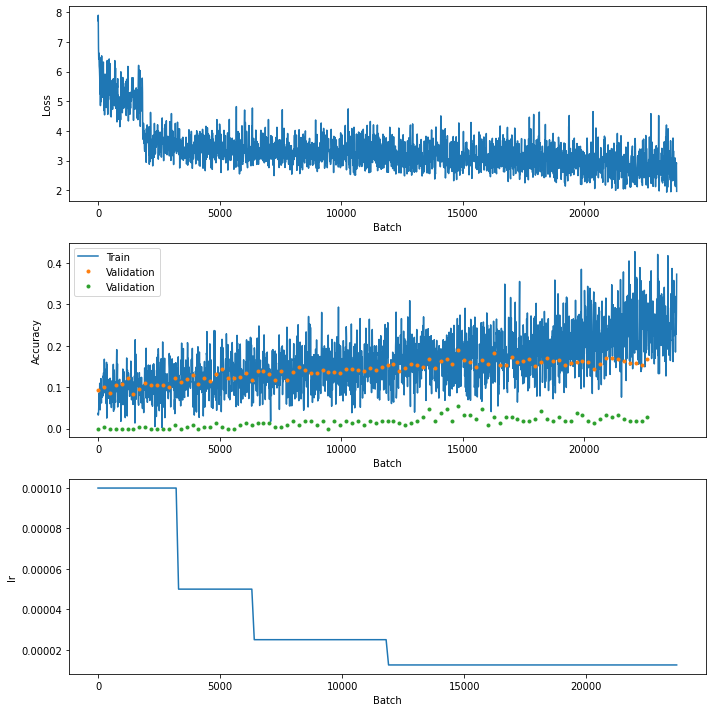

In [24]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
axs = axs.flatten()
#batch_iterations = np.arange(0, len(train_dl)*NUM_EPOCHS+1, 10)
batch_iterations = np.arange(0, len(running_loss)*10, 10)
val_iterations = np.arange(0, len(val_accuracy)*len(train_dl), len(train_dl))
axs[0].plot(batch_iterations, running_loss)
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

axs[1].plot(batch_iterations, running_semantic_accuracy, label='Train')
#axs[1].plot(batch_iterations[0:-1:int(np.ceil(len(running_loss)/10))], val_accuracy, '.', label='Validation')
axs[1].plot(val_iterations, val_accuracy, '.', label='Validation')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(batch_iterations[:-1:10], np.array(lr_monitor).squeeze()[0:-1:10])
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('lr')

#axs[3].plot(batch_iterations[:-1], val_accuracy)
#axs[3].set_xlabel('Batch')
#axs[3].set_ylabel('lr')

fig.tight_layout() 



In [84]:
acc_test, above_thresh_test = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=False)
acc_train, above_thresh_train = calculate_accuracy_on_test(encoder, decoder, train_dl, device, return_best_batch=False)

print(f"Test: {acc_test}, {above_thresh_test*100}%")
print(f"Train: {acc_train}, {above_thresh_train*100}%")

Test: 0.1475307856287275, 1.7857142857142856%
Train: 0.2135409453247555, 8.024691358024691%


In [59]:
type(list(test_dl)[0]['caption'])

list

In [78]:
#acc, best_batch = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=True)
#best_k_val = get_k_best(encoder, decoder, val_dl, 6, device)
#best_k_train = get_k_best(encoder, decoder, train_dl, 20,)
best_k_test = get_k_best_torch(encoder, decoder, test_dl, 10, device)

In [79]:
#best_k_train['image'] = best_k_train['image'].cpu()
#best_k_train['fmri'] = best_k_train['fmri'].cpu()
#best_k_train['accuracy'] = best_k_train['accuracy'].cpu()
#best_k_train_records = [dict(zip(best_k_train,t)) for t in zip(*best_k_train.values())]

best_k_test['image'] = best_k_test['image'].cpu()
best_k_test['fmri'] = best_k_test['fmri'].cpu()
best_k_test['accuracy'] = best_k_test['accuracy'].cpu()
best_k_test_records = [dict(zip(best_k_test,t)) for t in zip(*best_k_test.values())]


(0) Generated: <|endoftext|>One of the air jets fly over the grass at Texas which is from another plane.
   Real: A jet plane that is flying in the sky.  Accuracy: 0.5822411179542542
(1) Generated: <|endoftext|>Vintage bicycle sticker hanging on top of motorcycle parked near train station.
   Real: The handlebars of a motorcycle as well as the speedometer.   Accuracy: 0.4699177145957947
(2) Generated: <|endoftext|>A large pot and all the rest of the kitchen appliances sitting on a table.
   Real: A group of people sitting at a dining table.  Accuracy: 0.4252389967441559
(3) Generated: <|endoftext|>A plate containing a table and an ice cream cone is sitting on top of a table with a pasta peel.
   Real: Doughnuts on a plate being cut in  half by someone.  Accuracy: 0.4000820219516754
(4) Generated: <|endoftext|>A horse riding on a grassy bikeshull in the dirt.
   Real: Some racers on motorcycles on  narrow dirt track.  Accuracy: 0.39111754298210144
(5) Generated: <|endoftext|>A star card

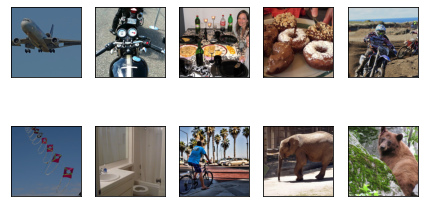

In [80]:
print_batch(best_k_test_records, fontsize=10, num_of_columns=5, caption_as_title=False)

In [ ]:
print(len(best_k_train_records))
print_batch(best_k_train_records, fontsize=10, num_of_columns=5, caption_as_title=False)
